In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
!pip install transformers datasets sentencepiece

In [3]:
from datasets import load_dataset
# possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset("kde4", lang1="en", lang2="fr", trust_remote_code=True)
data

kde4.py:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [4]:
small = data["train"].shuffle(seed=42).select(range(1_000))

In [5]:
split = small.train_test_split(seed=42)

In [6]:
split["train"][0]

{'id': '169005',
 'translation': {'en': '& Reduce Tree', 'fr': "& Refermer l' arborescence"}}

In [7]:
from transformers import AutoTokenizer

checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

('You can either pick a file or enter its name in the Location: box.',
 'Vous pouvez soit choisir un fichier soit saisir son nom dans la zone de texte Emplacement.')

In [9]:
inputs = tokenizer(en)
inputs

{'input_ids': [213, 115, 1828, 8437, 15, 1437, 57, 3307, 96, 1129, 18, 4, 4577, 37, 5311, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
targets = tokenizer(text_target=fr)
targets

{'input_ids': [344, 1069, 345, 4094, 34, 2428, 345, 9315, 113, 689, 31, 8, 1283, 5, 1470, 21708, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Vous',
 '▁pouvez',
 '▁soit',
 '▁choisir',
 '▁un',
 '▁fichier',
 '▁soit',
 '▁saisir',
 '▁son',
 '▁nom',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁texte',
 '▁Emplacement',
 '.',
 '</s>']

In [12]:
# wrong language
bad_targets = tokenizer(fr)
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁V',
 'ous',
 '▁po',
 'uv',
 'ez',
 '▁so',
 'it',
 '▁cho',
 'is',
 'ir',
 '▁un',
 '▁fi',
 'chi',
 'er',
 '▁so',
 'it',
 '▁s',
 'ais',
 'ir',
 '▁son',
 '▁no',
 'm',
 '▁dans',
 '▁la',
 '▁zone',
 '▁de',
 '▁text',
 'e',
 '▁Em',
 'placement',
 '.',
 '</s>']

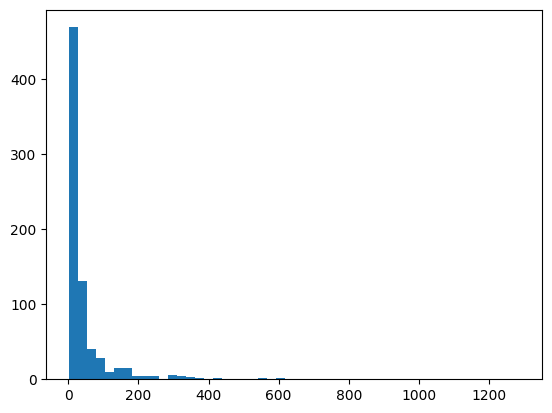

In [13]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

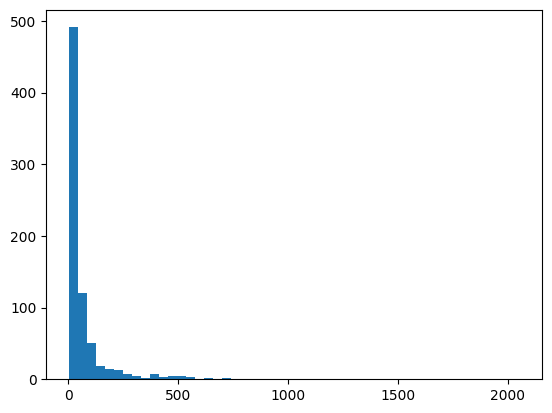

In [14]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

In [15]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)
  
  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [16]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [17]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [18]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [19]:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [526, 3261, 0],
  'attention_mask': [1, 1, 1],
  'labels': [526, 3261, 0]},
 {'input_ids': [3492,
   3070,
   6443,
   37,
   443,
   61,
   32,
   317,
   2203,
   4824,
   514,
   1807,
   971,
   4,
   4124,
   3,
   0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [34023,
   5,
   3948,
   5,
   372,
   402,
   38492,
   350,
   823,
   95,
   13439,
   2,
   25985,
   14,
   6,
   3996,
   3,
   0]}]

In [20]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [21]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from
# previous words!
batch["decoder_input_ids"]

tensor([[59513,   526,  3261,     0, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513],
        [59513, 34023,     5,  3948,     5,   372,   402, 38492,   350,   823,
            95, 13439,     2, 25985,    14,     6,  3996,     3]])

In [22]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁K',
 'DE',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [23]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁K',
 'DE',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [24]:
split['train'][1]

{'id': '47571', 'translation': {'en': 'KDE', 'fr': 'KDE'}}

In [25]:
!pip install sacrebleu bert-score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00


In [26]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00


In [27]:
from evaluate import load

bleu_metric = load("sacrebleu")
bert_metric = load("bertscore")

In [28]:
# targets must be in a list - as you recall, for bleu there can be multiple
# acceptable reference translations
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [29]:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [30]:

bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803367853164673],
 'recall': [0.9803367853164673],
 'f1': [0.9803367853164673],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.45.1)'}

In [31]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

In [32]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [33]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [34]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'eval_loss': 1.595541000366211,
 'eval_model_preparation_time': 0.0057,
 'eval_bleu': 38.896155773030536,
 'eval_bert_score': 0.8636420161724091,
 'eval_runtime': 28.296,
 'eval_samples_per_second': 8.835,
 'eval_steps_per_second': 0.141}

In [35]:
# may run out of gpu memory - try to restart runtime
# or get a more powerful gpu!
trainer.train()

Step,Training Loss


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=72, training_loss=1.5120711856418185, metrics={'train_runtime': 28.477, 'train_samples_per_second': 79.011, 'train_steps_per_second': 2.528, 'total_flos': 51206128533504.0, 'train_loss': 1.5120711856418185, 'epoch': 3.0})

In [36]:
# let's check our metrics again
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.3866868019104004,
 'eval_model_preparation_time': 0.0057,
 'eval_bleu': 43.936615063690354,
 'eval_bert_score': 0.879831332206726,
 'eval_runtime': 19.3074,
 'eval_samples_per_second': 12.948,
 'eval_steps_per_second': 0.207,
 'epoch': 3.0}

In [37]:
trainer.save_model("my_saved_model")

In [38]:
from transformers import pipeline
translator = pipeline("translation", model='my_saved_model', device=0)

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [39]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]